# Train the motif ai model

Using the pretrained model ResNet50 with the weights from the ImageNet contest.

In [2]:
IMAGE_RESIZE_SIZE = 224

PATH_TO_TRAIN_DATA = '../../../image-data/preprocessed'
SPLIT_DATA = False

BATCH_SIZE_TRAIN = 32
BATCH_SIZE_VAL = 32

EPOCHS = 15

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import preprocess_input
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping
from keras.applications import ResNet50
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.layers import Dense
import seaborn as sns
import pickle as pkl
import splitfolders
import numpy as np
import shutil
import time
import os

In [3]:
print (f"Loading data from {os.path.abspath(PATH_TO_TRAIN_DATA)}...")
categories = os.listdir(os.path.join(PATH_TO_TRAIN_DATA, 'train') if os.path.exists(os.path.join(PATH_TO_TRAIN_DATA, 'train')) else PATH_TO_TRAIN_DATA)
NUM_CLASSES = len(categories)
print (f"Found {NUM_CLASSES} categories: {categories}")
original_count = sum([len(files) for _, _, files in os.walk(PATH_TO_TRAIN_DATA)])
print (f"Found {original_count} images in total.")

if SPLIT_DATA:
    original_path = os.path.join(PATH_TO_TRAIN_DATA, 'original')
    os.makedirs(original_path)
    for category in categories:
        shutil.move(os.path.join(PATH_TO_TRAIN_DATA, category), os.path.join(original_path, category))
    while sum([len(files) for _, _, files in os.walk(original_path)]) != original_count:
        time.sleep(2)
    print ("Splitting data into train and val folders...")
    new_data_path = os.path.join(PATH_TO_TRAIN_DATA, 'preprocessed')
    splitfolders.ratio(original_path, output=new_data_path, seed=1337, ratio=(.7, .2, .1))
    PATH_TO_TRAIN_DATA = new_data_path
    print (f"Splitting complete. New data path: {os.path.abspath(PATH_TO_TRAIN_DATA)}")

TRAIN_DATA_PATH = os.path.join(PATH_TO_TRAIN_DATA, 'train')
VAL_DATA_PATH = os.path.join(PATH_TO_TRAIN_DATA, 'val')
TEST_DATA_PATH = os.path.join(PATH_TO_TRAIN_DATA, 'test')

Loading data from c:\Users\Lenovo\Documents\Skripte\python\image-data\preprocessed...
Found 8 categories: ['flowers', 'landscape', 'people', 'portrait', 'still', 'street', 'underwater', 'wildlife']
Found 307 images in total.


In [5]:
pkl.dump(categories, open('categories.pkl', 'wb'))

In [109]:
data_generator = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=20,
        zoom_range=0.2,
        shear_range=0.2,
        horizontal_flip=True,
        validation_split=0.4)

In [110]:
train_generator = data_generator.flow_from_directory(
        TRAIN_DATA_PATH,
        target_size=(IMAGE_RESIZE_SIZE, IMAGE_RESIZE_SIZE),
        batch_size=BATCH_SIZE_TRAIN,
        class_mode='categorical',
        subset='training')

Found 131 images belonging to 8 classes.


In [111]:
validation_generator = data_generator.flow_from_directory(
        VAL_DATA_PATH,
        target_size=(IMAGE_RESIZE_SIZE, IMAGE_RESIZE_SIZE),
        batch_size=BATCH_SIZE_VAL,
        class_mode='categorical',
        subset='validation')

Found 21 images belonging to 8 classes.


In [112]:
test_generator = data_generator.flow_from_directory(
        TEST_DATA_PATH,
        target_size=(IMAGE_RESIZE_SIZE, IMAGE_RESIZE_SIZE),
        batch_size=BATCH_SIZE_VAL,
        class_mode='categorical',
        subset='validation')

Found 11 images belonging to 8 classes.


In [113]:
x, y = train_generator.next()
x.shape, y.shape

((32, 224, 224, 3), (32, 8))

In [114]:
model = Sequential()
model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.layers[0].trainable = False

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_3 (Dense)             (None, 8)                 16392     
                                                                 
Total params: 23,604,104
Trainable params: 16,392
Non-trainable params: 23,587,712
_________________________________________________________________


In [115]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [116]:
early_stopping = EarlyStopping(patience=2)
fit_history = model.fit(train_generator,
        epochs=EPOCHS,
        callbacks=[early_stopping],
        validation_data=validation_generator,
        verbose=1)

Epoch 1/15
5/5 [==============================] - 43s 8s/step - loss: 2.6754 - accuracy: 0.1985 - val_loss: 1.8494 - val_accuracy: 0.3810
Epoch 2/15
5/5 [==============================] - 32s 6s/step - loss: 1.5266 - accuracy: 0.5344 - val_loss: 1.3761 - val_accuracy: 0.5714
Epoch 3/15
5/5 [==============================] - 38s 7s/step - loss: 1.1075 - accuracy: 0.6565 - val_loss: 1.0701 - val_accuracy: 0.6190
Epoch 4/15
5/5 [==============================] - 47s 9s/step - loss: 0.6757 - accuracy: 0.8168 - val_loss: 0.7536 - val_accuracy: 0.7143
Epoch 5/15
5/5 [==============================] - 36s 7s/step - loss: 0.5180 - accuracy: 0.8321 - val_loss: 0.5145 - val_accuracy: 0.7619
Epoch 6/15
5/5 [==============================] - 32s 6s/step - loss: 0.3722 - accuracy: 0.8931 - val_loss: 0.4278 - val_accuracy: 0.8571
Epoch 7/15
5/5 [==============================] - 32s 6s/step - loss: 0.2654 - accuracy: 0.9160 - val_loss: 0.3958 - val_accuracy: 0.9048
Epoch 8/15
5/5 [==================

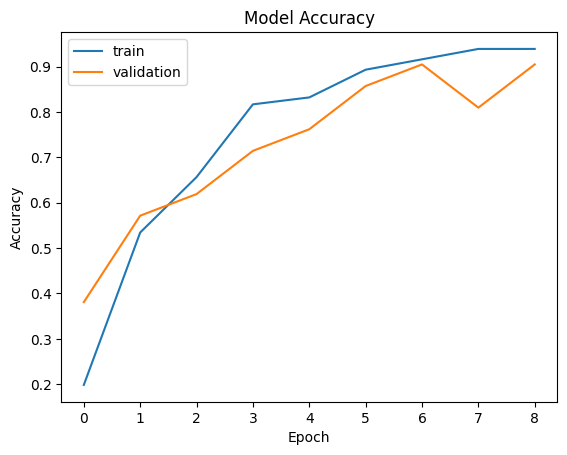

In [117]:
plt.plot(fit_history.history['accuracy'])
plt.plot(fit_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

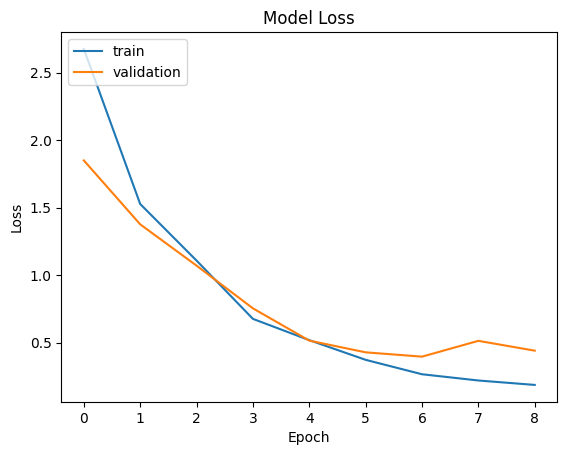

In [118]:
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [119]:
model.save('resnet50_motif.h5')

In [120]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)

1/1 - 2s - loss: 0.1580 - accuracy: 1.0000 - 2s/epoch - 2s/step


1/1 [==============================] - 5s 5s/step


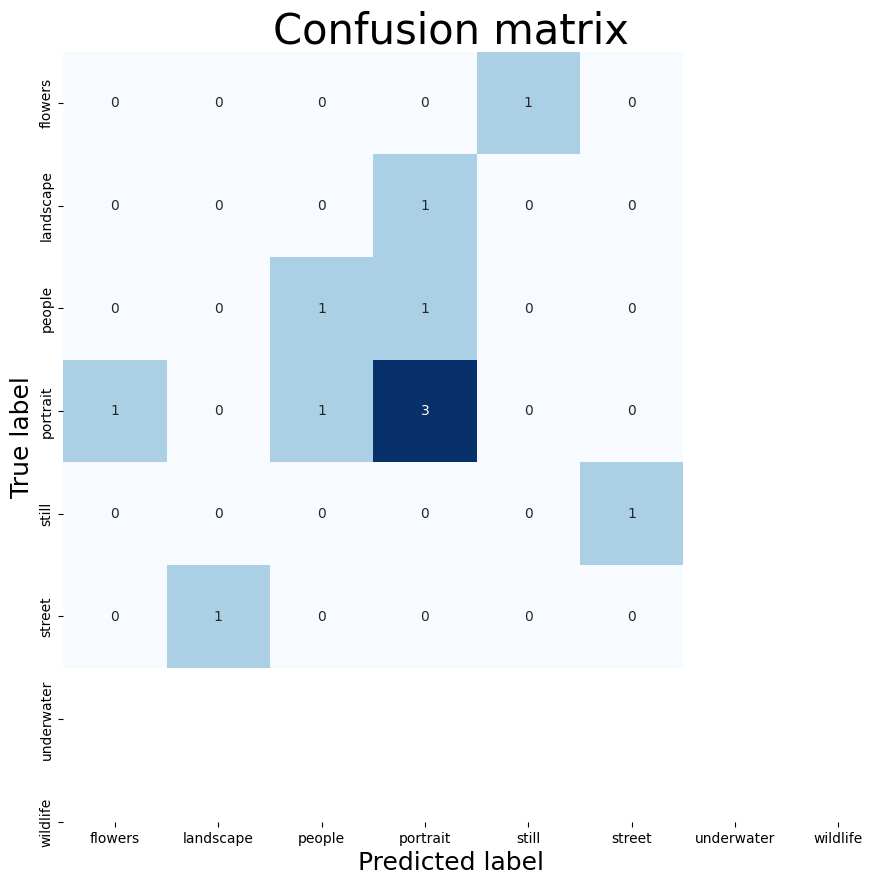

In [121]:
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=categories, yticklabels=categories)
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=18)
plt.xlabel('Predicted label', fontsize=18)
plt.show()

In [ ]:
test_generator.reset()
files = test_generator.filenames
results = model.predict(test_generator)
results = np.argmax(results, axis=1)

fig, ax = plt.subplots(5, len(files) // 5)

idx = 0
for i in range(5):
    for j in range(len(files) // 5):
        ax[i, j].imshow(plt.imread(os.path.join(TEST_DATA_PATH, files[idx])), cmap='gray')
        ax[i, j].set_title(f"Predicted: {categories[results[idx]]}\nActual: {categories[test_generator.classes[idx]]}")
        ax[i, j].axis('off')
        idx += 1

plt.show()
